In [40]:
import numpy as np
import pandas as pd
import os
import datetime
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Baseline: K Nearest Neighbors Classification 

### Load leaf count data

In [41]:
df = pd.DataFrame.from_csv('data.csv')    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


### Add new column of best guess at leaf count based by taking average of minimum and maximum

In [42]:
df['avg'] = df.apply(lambda x: (x['minimum']+x['maximum'])/2, axis=1)


### Examine sample of leaf data

In [43]:
df.sample(10)

,minimum,maximum,avg
image_id,,,
221,6,8,7.0
1564,9,11,10.0
1537,6,7,6.5
576,7,9,8.0
1683,6,8,7.0
1168,8,10,9.0
30,6,9,7.5
1443,10,13,11.5
464,11,12,11.5


### Examine distribution of leaf counts per plant

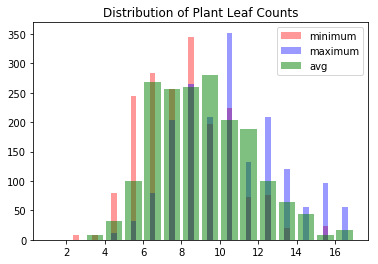

In [44]:
plt.hist(df.minimum, bins=[i for i in range(1, 18)], color='r', alpha=0.4, rwidth=0.3, label='minimum')
plt.hist(df.maximum, bins=[i for i in range(1, 18)], color='b', alpha=0.4, rwidth=0.3, label='maximum')
plt.hist(df.avg, bins=[i for i in range(1, 18)], color='g', alpha=0.5, rwidth=0.85, label='avg')
plt.legend(loc='upper right')
plt.title('Distribution of Plant Leaf Counts')
plt.show()

### Examine sample image

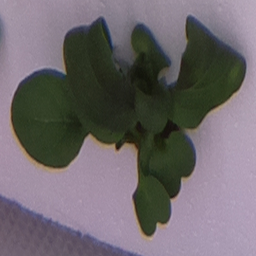

In [45]:
Image.open('plants_augmented/plant_1.png')

### Convert sample image to grayscale

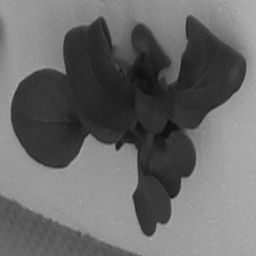

In [46]:
Image.open('plants_augmented/plant_1.png').convert('L')

### Load image data, convert to grayscale, and then convert to array

In [47]:
image_data = [np.array(Image.open('plants_augmented/plant_{}.png'.format(n)).convert('L')) for n in df.index]


### Examine distribution of grayscale pixel values

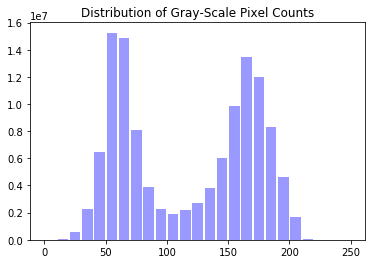

In [48]:
grayscale_pixels = []
for i in range(len(image_data)): 
    grayscale_pixels += list(image_data[i].flatten())

plt.hist(grayscale_pixels, bins=[i for i in range(0, 256, 10)], color='b', alpha=0.4, rwidth=0.85)
plt.title('Distribution of Gray-Scale Pixel Counts')
plt.show()


There is a clear bimodal distribution of grayscale pixel values, which is what we expect to see for images of dark foreground objects against a lighter background. 

### Separate training set (85%) and test set (15%)

In [49]:
mask = np.random.rand(len(df)) <= 0.85
df_train = df[mask]
df_test = df[~mask]

### Make x_train, y_train, x_test, and y_test

For the baseline only, we will use the minimum number of leaves per plant as a stand-in for the best guess of the true number of leaves. This is because KNN is an algorithm for classification tasks, and therefore we need our labels to be whole numbers so that they can be treated as robust classes. In contrast, the average can be a float, which would break our class requirement.

In [50]:
x_train = [image_data[i].flatten() for i, x in enumerate(list(mask)) if x == True]
x_test = [image_data[i].flatten() for i, x in enumerate(list(mask)) if x == False]

y_train = list(df_train['minimum'])
y_test = list(df_test['minimum'])

### Pool of K values to test: 1, 2, 3, 5, 10, 15

In [51]:
model_1NN = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
model_2NN = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
model_3NN = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
model_5NN = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model_10NN = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_15NN = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)

model_pool = [(1, model_1NN),
              (2, model_2NN),
              (3, model_3NN),
              (5, model_5NN),
              (10, model_10NN),
              (15, model_15NN)]

for k, model in model_pool: 
    model.fit(x_train, y_train)


### Class prediction accuracy: exact class predictions

In [52]:
for k, model in model_pool:
    print('K = {}: {}'.format(k, round(model.score(x_test, y_test), 3)))


K = 1: 0.154
K = 2: 0.147
K = 3: 0.14
K = 5: 0.14
K = 10: 0.13
K = 15: 0.112


### Class prediction accuracy: within range of plus-or-minus 1

In [54]:
TOLERANCE = 1

for k, model in model_pool:
    pred = model.predict(x_test)
    acc = sum([1 for i, y_hat in enumerate(pred) if abs(y_hat - y_test[i]) <= df['maximum'].iloc[i]-df['minimum'].iloc[i]]) / len(y_test)

    print('K = {}: {}'.format(k, round(acc, 3)))


K = 1: 0.677
K = 2: 0.642
K = 3: 0.586
K = 5: 0.589
K = 10: 0.667
K = 15: 0.691


### Class prediction accuracy: confusion matrix

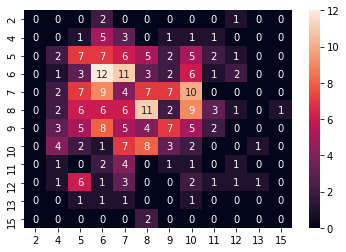

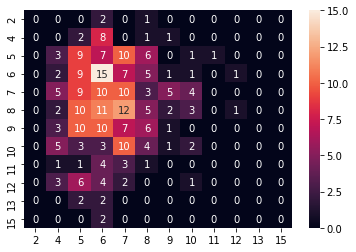

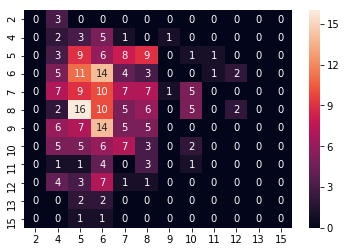

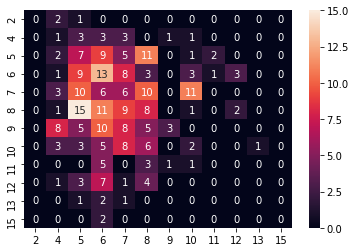

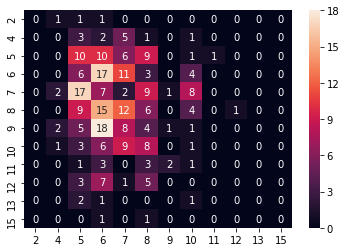

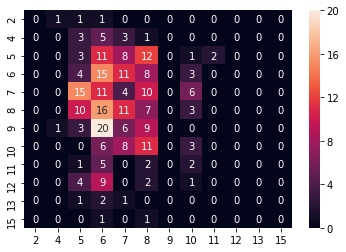

In [55]:
for k, model in model_pool:
    pred = model.predict(x_test)
    arr = confusion_matrix(y_test, pred, labels=np.unique(y_test))
    df_cm = pd.DataFrame(arr, index=[i for i in np.unique(y_test)], columns=[i for i in np.unique(y_test)])
    sns.heatmap(df_cm, annot=True)
    plt.show()
    